# Build HPPC Plot

Make a plot to show what the HPPC test looks like

In [1]:
import os, sys

if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')
    
import numpy as np
import pandas as pd
import glob
import yaml
from datetime import datetime
import seaborn as sns
from matplotlib import pyplot as plt
import re

## Configure plot settings

In [2]:
# Configure plot settings
plt.rc('font', **{'family'     : 'sans-serif',
                  'sans-serif' : ['Helvetica'],
                  'size': 26
                  })
plt.rc('figure', **{'autolayout' : True,
                    'figsize'    : (10, 8)
                    })
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('axes',  labelsize='medium', grid=True)
plt.rc('axes',  titlesize='medium')
plt.rc('legend', fontsize='medium')
plt.rc('image',  cmap='gray')

DPI = 600
VOLTAGE_LIMITS = (2.95, 4.25)
CAPACITY_LIMITS = (0, 3)

ORANGE = (1, 0.5, 0)
BLUE = (0, 0.5, 1)
BLACK = (0.0, 0.0, 0.0)
GREEN = (0, 0.75, 0)
ORANGE = (1, 0.5, 0)

## Configure project file path settings

In [3]:
paths = yaml.load(open('paths.yaml', 'r'), Loader=yaml.FullLoader)

PROJECT_FOLDER = '2020-10-aging-test-timeseries/'

GROUP_LIST = ['Baseline HT', 'Baseline RT', 'MicroForm HT', 'MicroForm RT']
FORMATION_TYPE = ['Baseline', 'Baseline', 'MicroForm', 'MicroForm']
TEST_TEMPERATURE = ['HT', 'RT', 'HT', 'RT']
FILE_GROUP_REGEX_LIST = ['UM_Internal_0620_-_BL_Form_-_HT-_Cycling_Cell_[0-9]*.[0-9]*.csv',
                         'UM_Internal_0620_-_BL_Form_-_Cycling_Cell_[0-9]*.[0-9]*.csv',
                         'UM_Internal_0620_-_Micro_Form_-_HT-_Cycling_Cell_[0-9]*.[0-9]*.csv',
                         'UM_Internal_0620_-_Micro_Form_-_Cycling_Cell_[0-9]*.[0-9]*.csv']

STEP_INDEX_C3_CHARGE = 7
STEP_INDEX_C3_DISCHARGE = 10
STEP_INDEX_C20_CHARGE = 13
STEP_INDEX_C20_DISCHARGE = 16
STEP_INDEX_HPPC_CHARGE = 22
STEP_INDEX_HPPC_DISCHARGE = 24

DATA_PATH = paths['data']
OUTPUT_PATH = paths['outputs']


In [4]:
fpath_group_list = [sorted(glob.glob(f'{DATA_PATH}{PROJECT_FOLDER}{f}')) for f in FILE_GROUP_REGEX_LIST]

## Load resources

In [5]:
def process_hppc_pulses(df_raw_data):
    """ 
    Takes in raw data and returns a data structure holding processed HPPC pulse information
    
    Uses step indices to infer start and end of each pulse.

    Args:
      df_raw_data (Pandas DataFrame)

    Returns a tuple (cycle indices, results)
        cycle indices (list) refers to the HPPC cycles
        results (list) is a list of Pandas DataFrames. Each DataFrame holds the contents 
           of the HPPC test result for the given cycle index 
    """


    df_hppc = df_raw_data[df_raw_data['Step Index'] == STEP_INDEX_HPPC_DISCHARGE]
    hppc_cycle_indices = np.unique(df_hppc['Cycle Number'])

    all_results = list()

    # Loop through each diagnostic test
    for curr_cyc in hppc_cycle_indices:

        curr_df = df_raw_data[df_raw_data['Cycle Number'] == curr_cyc]
        
        # Process each pulse 
        pulse_list = []
        for idx, point in enumerate(curr_df['Step Index'].values):
            
            if idx == 0: 
                continue

            # Detect pulse start
            if point == STEP_INDEX_HPPC_DISCHARGE \
                and curr_df['Step Index'].iloc[idx-1] != STEP_INDEX_HPPC_DISCHARGE:

                capacity = curr_df['Charge Capacity (Ah)'].iloc[idx-1]
                voltage_0 = curr_df['Potential (V)'].iloc[idx-1]

                # Detect pulse end
                voltage_1 = voltage_0
                jdx = idx + 1
                while True:
                    jdx += 1
                    if curr_df['Step Index'].iloc[jdx] != STEP_INDEX_HPPC_DISCHARGE:
                        voltage_1 = curr_df['Potential (V)'].iloc[jdx-1]
                        break

                duration_in_seconds = curr_df['Test Time (s)'].iloc[jdx] - \
                                      curr_df['Test Time (s)'].iloc[idx]
                
                current = np.abs(np.mean(curr_df['Current (A)'].iloc[idx:jdx]))
                resistance = (voltage_0 - voltage_1)/current

                result = dict()
                result['capacity'] = capacity
                result['voltage'] = voltage_0
                result['resistance'] = resistance
                result['current'] = current
                result['duration_in_seconds'] = duration_in_seconds

                pulse_list.append(result)

        result = pd.DataFrame(pulse_list)

        all_results.append(result)

    return (hppc_cycle_indices, all_results)

In [6]:
# Create a dictionary of values
#
# - key: group (e.g. 'Baseline HT')
#   - key: cellid 
#     - values

data = dict()

for group_name, file_list in zip(GROUP_LIST, fpath_group_list):

    curr_data = dict()
    for file_path in file_list:

        print(f'Loading raw data from {file_path}...')
        
        # Get raw data
        df_raw_data = pd.read_csv(file_path)
        # Do a bit of post-processing
        df_raw_data['Timestamp'] = pd.to_datetime(df_raw_data['Timestamp'], unit='ms')
        df_raw_data['Cycle Number'] += 1

        # Get cellid
        cellid = re.findall('\_[0-9]*.\.', file_path)
        cellid = int(cellid[0][1:-1])
        
        # Get cycle-by-cycle data, derived from raw data DataFrame
        df_cycle = df_raw_data \
                   .groupby('Cycle Number', as_index=False) \
                   .agg({
                       'Charge Capacity (Ah)': max, 
                       'Discharge Capacity (Ah)': max,
                       'Timestamp': min
                       })

        # Define coulombic efficiency cycle by cycle
        df_cycle['Coulombic Efficiency (%)'] = df_cycle['Discharge Capacity (Ah)']/df_cycle['Charge Capacity (Ah)']*100
        # Drop cycles with 0 charge capacity
        df_cycle = df_cycle[df_cycle['Charge Capacity (Ah)'] != 0]

        ## Get the features, cycle by cycle; derived from raw data DataFrame
        features_by_cycle_dict = dict()
        for n in df_raw_data['Cycle Number'].unique().tolist():
            iloc = df_raw_data['Cycle Number'] == n
            if max(df_raw_data['Charge Capacity (Ah)'][iloc]) == 0:
                continue
            features_dict = dict()
            features_dict['n'] = n
            features_dict['Q'] = df_raw_data['Charge Capacity (Ah)'][iloc]
            features_dict['V'] = df_raw_data['Potential (V)'][iloc]
            features_dict['dQdV'] = df_raw_data['dQ/dV (Ah/V)'][iloc]
            features_dict['Qd'] = df_raw_data['Discharge Capacity (Ah)'][iloc]
            features_by_cycle_dict[n] = features_dict

        # Package the data
        features = dict()
        features['raw'] = df_raw_data
        features['cycle'] = df_cycle
        features['features'] = features_dict
        features['hppc'] = process_hppc_pulses(df_raw_data)

        # Assignment into dict value
        curr_data[cellid] = features

    data[group_name] = curr_data

print('Done')


Loading raw data from /Users/aweng/Documents/fast-formation/data/2020-10-aging-test-timeseries/UM_Internal_0620_-_BL_Form_-_HT-_Cycling_Cell_1.022.csv...
Loading raw data from /Users/aweng/Documents/fast-formation/data/2020-10-aging-test-timeseries/UM_Internal_0620_-_BL_Form_-_HT-_Cycling_Cell_10.031.csv...
Loading raw data from /Users/aweng/Documents/fast-formation/data/2020-10-aging-test-timeseries/UM_Internal_0620_-_BL_Form_-_HT-_Cycling_Cell_2.023.csv...
Loading raw data from /Users/aweng/Documents/fast-formation/data/2020-10-aging-test-timeseries/UM_Internal_0620_-_BL_Form_-_HT-_Cycling_Cell_3.024.csv...
Loading raw data from /Users/aweng/Documents/fast-formation/data/2020-10-aging-test-timeseries/UM_Internal_0620_-_BL_Form_-_HT-_Cycling_Cell_4.025.csv...
Loading raw data from /Users/aweng/Documents/fast-formation/data/2020-10-aging-test-timeseries/UM_Internal_0620_-_BL_Form_-_HT-_Cycling_Cell_5.026.csv...
Loading raw data from /Users/aweng/Documents/fast-formation/data/2020-10-ag

## View available data

In [7]:
for group in data.keys():
    print(f'Group: {group}')
    print(f' -> cellids: {data[group].keys()}')
    print('')

Group: Baseline HT
 -> cellids: dict_keys([1, 10, 2, 3, 4, 5, 6, 7, 8, 9])

Group: Baseline RT
 -> cellids: dict_keys([11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

Group: MicroForm HT
 -> cellids: dict_keys([31, 32, 33, 34, 35, 36, 37, 38, 39, 40])

Group: MicroForm RT
 -> cellids: dict_keys([21, 22, 23, 24, 25, 26, 27, 28, 29, 30])



In [8]:
GROUP = 'Baseline HT'
CELLID = 1

feature = data[GROUP][CELLID]

## Plot an example of the HPPC pulsetrain 

Show how DC resistance is calculated from this

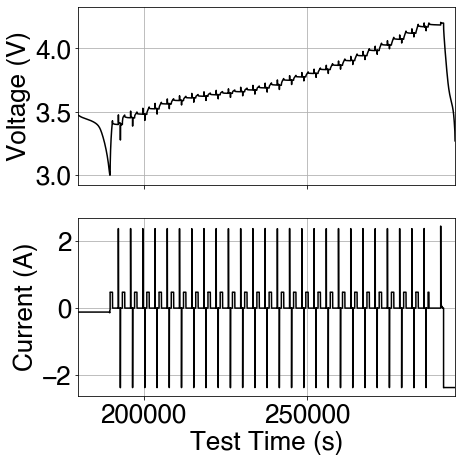

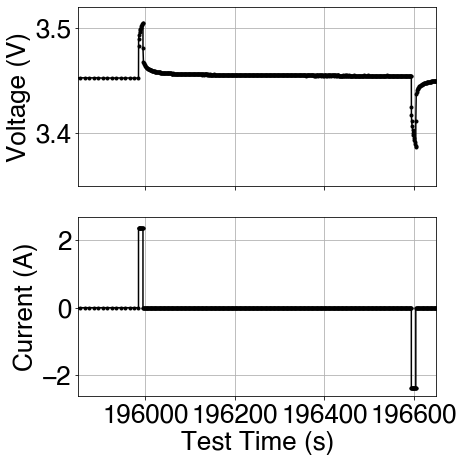

In [9]:
voltage = feature['raw']['Potential (V)']
current = feature['raw']['Current (A)']
time_in_seconds = feature['raw']['Test Time (s)']

# Zoomed out
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7,7))

XLIM_MIN = 180000
XLIM_SPAN = 32*60*60

ax1.plot(time_in_seconds, voltage, color='black')
ax1.set_ylabel('Voltage (V)')

ax2.plot(time_in_seconds, current, color='black')
ax2.set_xlabel('Test Time (s)')
ax2.set_ylabel('Current (A)')

plt.xlim((XLIM_MIN, XLIM_MIN + XLIM_SPAN))
plt.show()

# Zoomed in
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7,7))

XLIM_MIN = 195850
XLIM_MAX = 196650
YLIM_VOLTAGE = (3.35, 3.52)

ax1.plot(time_in_seconds, voltage, 'o-', markersize=3, color='black')
ax1.set_ylabel('Voltage (V)')
ax1.set_ylim(YLIM_VOLTAGE)

ax2.plot(time_in_seconds, current, 'o-', markersize=3, color='black')
ax2.set_xlabel('Test Time (s)')
ax2.set_ylabel('Current (A)')

plt.xlim((XLIM_MIN, XLIM_MAX))
plt.show()
